# Queuing Theory for Software Engineers

- Capacity planning -> from DAU to throughput
- Predicting software performance with Little's Law
- Monitoring Queues
- Traffic shaping with Queues
- Answering to saturation examples: https://sre.google/sre-book/monitoring-distributed-systems/#xref_monitoring_golden-signals

## "Start with Why"
Queues are a built-in mechanism everywhere in today's software. Not being familiar with the basics of queuing theory will prevent you from understanding the relations between latency & throughput, high-level capacity estimations, and workload optimization. Knowing the internals of queuing models is actually not that hard to grasp. In this article, I'll sum up the essence of what's required for a software engineer to be more effective in their field.

### Queues Are Everywhere!
⚠️TODO
- Fork-join pool with work-stealing mechanism
- Java thread pools & unbounded queues
- Scylla DB?
- Resilience4J - Bulkheads
- https://sre.google/sre-book/monitoring-distributed-systems/#xref_monitoring_golden-signals

# The Basics
Let's cover the basic concepts first before we discuss practical applications. What are the key metrics that are in play, when we're investigating a queue? We have the following relevant metrics when talking about queues in general.

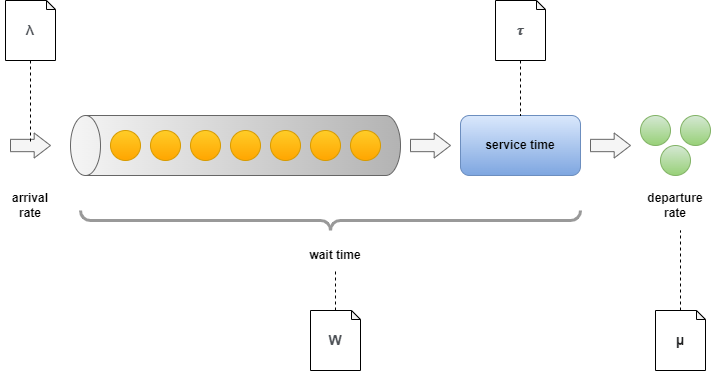

## Description of each term

- **Arrival rate:** ($\lambda$) The rate at which new work items arrive in the queue. 
- **Wait time:** ($W$) The total time spent by each work item in the system. Usually composed of two elements. Time spent in the queue (determined by preceding work items) and time spent with service. 
- **Servers:** ($c$) Referring to the level of parallelization. 
- **Service time:** ($\tau=1/\mu$) The time required to process a single work item. It's often translated to rate and called **departure rate**. 
- **Departure rate:** ($\mu$) The rate at which items are processed. 
- **Utilization:** ($\rho=\lambda/\mu$) Simply describes the ratio between arrival and departure rate.
- **Number of items being served ($L$):** Total elements in the system, including those being processed and waiting in the queue.

### Matching with practical naming and notation
In software engineering, we use slightly different terms when talking about performance. You can find a mapping between the notation used in queuing theory and their counterpart:

| Naming in model  | Naming in software systems   | Description |
| ---------------: | :--------------------------: | :---------- | 
| arrival rate/departure rate | throughput/load | It's good to distinguish between the two depending on the context. Arrival rate often referred to as load, load average |
| wait time | latency | None of them distinguishes between wait time in the queue and waiting because of being served. |
| servers | executors/processors | We mostly mean the number of CPUs/workers on that |
| service time | execution time/duration | Measured as the time required to do a single task. Often just mixed with latency. |
| utilization | utilization | Practically utilization is calculated with various methods. Often it means the ratio of unutilized CPU ticks and utilized ones over a given time window (e.g. 5 seconds). | 
| queue length | saturation | Most often they indicate the same thing: What's the extra workload the system has to cope with? The most popular usage of the term "saturation" comes from the [four golden signals](https://sre.google/sre-book/monitoring-distributed-systems/#xref_monitoring_golden-signals) mentioned in the Google SRE book.  |

### Simple use-cases
#### Sequential
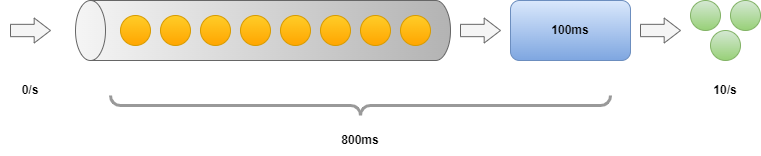

Now let's imagine having a simple queue like the one above. We have **8** items in the queue and **no new arrivals**, The execution duration is $100 ms$. What are the throughput and latency? We can produce a green marble in every $100 ms$, so that gives us $10 /s$. The latency is a bit trickier to determine. The first item will have $100 ms$ latency. The last item requires all the previous ones to be processed, so its latency will be $8 * 100ms$. So the minimum latency is $100 ms$, the maximum is $800 ms$ and the mean is $450 ms$.

#### Parallel
Let's try to increase the number of executors. How the previous use-case is changing if we add another one?

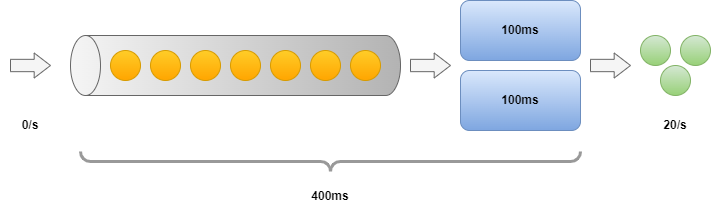

We can now produce 2 work items in every $100 ms$, so throughput is doubled to $20/s$. The first item requires $100 ms$ to process and the last one needs $400 ms$ (we can take 2 items on each $100 ms$ period). So the minimum latency is $100 ms$, the maximum is $400 ms$ and the mean is $250 ms$. 

> An immediate important observation to make is that **the latency we're experiencing is determined by where we're sitting in the queue:** If the queue is empty or nearly empty - **scaling out has literally no effect on the latency**. As we'll see in the upcoming sections, having an increased amount of work items queued up has its own negative implications.

#### Pipelines
How do things change if we split the work differently than in the previous example? Let's assume we now have two queues attached to each other with two executors. The overall execution time will be the same as before. Will splitting the work have any effect on the latency/throughput? 

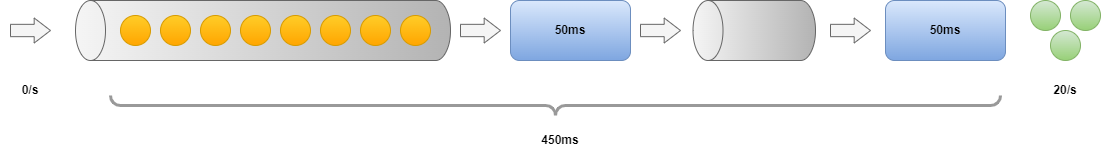

We can now produce 1 work item in every $50 ms$ doubling our throughput to $20 /s$. The first item still requires $100 ms$ to pass through, but the last one only needs $450 ms$. Imagine that after the first $100 ms$ - when the first item is processed we're going to see a new green marble in each $50 ms$ until the queue gets empty. The minimum latency is $100 ms$, the maximum is $450 ms$ and the mean is $275 ms$.

> This is where the power of **reactive libraries** comes from. Even though you might think you **write a sequential code** it's not executed as-is. Only your declaration of causation is sequential. You're declaring a pipeline of execution that splits your overall workload into smaller pieces and runs it in parallel. I can mention plenty of examples, like Kotlin coroutines, Java completable futures, the ReactiveX library, Akka, etc. **The observation above is still true: Latency is not changing if our queues have only a few elements**

> As you can see from the latency numbers above - **minimum values don't expose too much about the queue length**. On the other hand, **maximum latencies can indicate saturation**: it tells you how much time is spent on the queue throughout the system. If you don't know much about the duration of execution a way to get a hint on the saturation of a black-box system is to keep an eye on $max(latency) - min(latency)$ or $p99(latency) - avg(latency)$

> Another great way of visualizing latency distributions and getting hints on saturations is by using [heatmaps](https://www.brendangregg.com/heatmaps.html).

#### Bottleneck
What happens in those cases, when we have one executor in the pipeline whose latency takes the majority of the time? Let's see the example below:
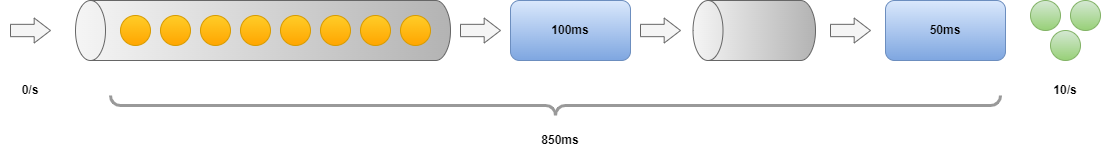

You can think about this case as a variety of the first exercise: Throughput is determined by the slowest executor as it's "choking" our pipeline. So we can only produce a marble in each $100 ms$ giving us the overall $10 /s$. The latency maximum is the same as for the first exercise, except that we have to pay an additional penalty of $+50 ms$ for each operation. So now we have the minimum latency of $150 ms$, mean at $500 ms$, and the maximum is $850 ms$.

> When we have a bottleneck in a situation as above, focusing on the slowest execution brings the most benefit. Feel free to compare the numbers with the previous exercise. We're benefiting from speedup both in latency and throughput.

## Advanced Use-Cases
To be able to investigate more advanced use cases, we're shifting gears. I'm going to use this [simple modeling library](https://github.com/gitaroktato/queue-model-in-python) for the next couple of sections.

### Stable and unstable situations
What happens if the utilization is higher than $100\%$? In these cases, the arrival rate is larger than our overall throughput. How is it affecting our latency? Our arrival interval ($100ms$) is going to be a bit less than our execution interval ($120ms$).


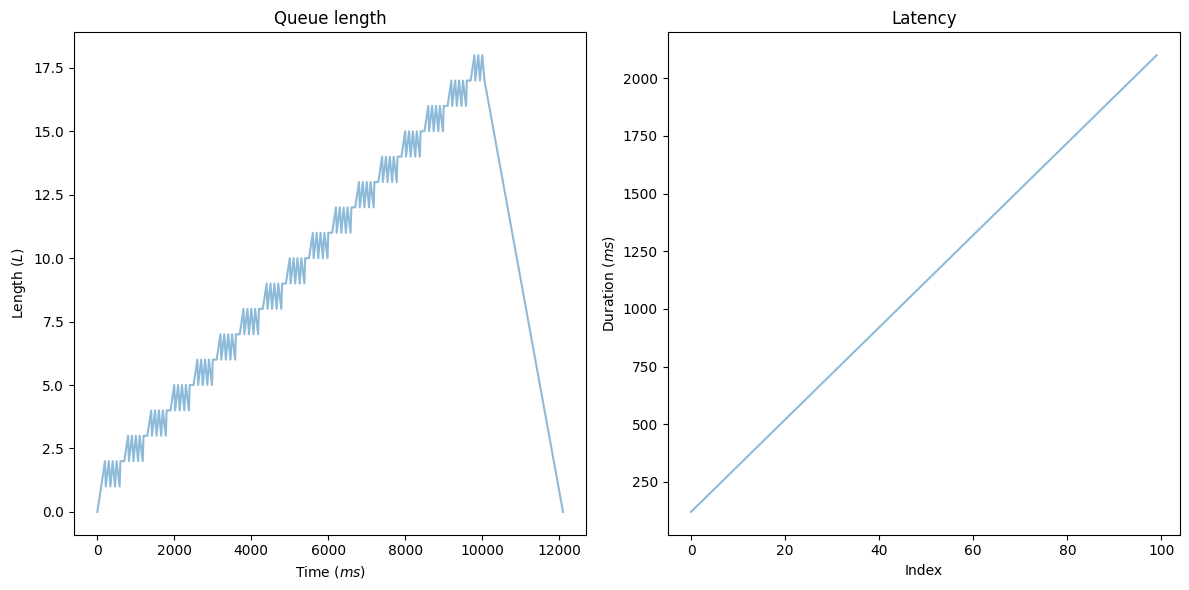

Latency min: 120
Latency average: 1110.0
Latency max: 2100


In [90]:
import matplotlib.pyplot as plt
import numpy as np
from src.queue import Queue

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

SAMPLE_SIZE = 100
ARRIVAL_INTERVAL = 100
EXECUTION_INTERVAL = 120
EXECUTORS = 1

inter_arrival_time = np.full(shape=SAMPLE_SIZE, dtype=int, fill_value=ARRIVAL_INTERVAL)

queue = Queue(inter_arrival_time, np.full(shape=SAMPLE_SIZE, dtype=int, fill_value=EXECUTION_INTERVAL), executors=EXECUTORS)
queue.process()

fig, (queue_length, latency) = plt.subplots(1, 2)

queue_length.set_title("Queue length")
queue_length.set(xlabel=r'Time ($ms$)', ylabel=r'Length ($L$)')
queue_length.plot(*zip(*queue.length_with_timestamps), alpha=0.5)

latency.set_title("Latency")
latency.set(xlabel='Index', ylabel=r'Duration ($ms$)')
latency.plot(queue.wait_times, alpha=0.5)

fig.tight_layout()
plt.show()

print(f'Latency min: {queue.wait_times.min()}')
print(f'Latency average: {queue.wait_times.mean()}')
print(f'Latency max: {queue.wait_times.max()}')

The queue length shows a linearly increasing number of elements. After we reach the `SAMPLE_SIZE`, the arrival rate drops to zero and the queue size starts decreasing linearly. The time window equals the total time required to process everything: $execution\ time * SAMPLE\_SIZE$. What does the diagram on the right tell us? We have a continuously increasing latency. 
> If the arrival rate is greater than your throughput, your system must take action. You have two options here:
> - Scaling out executors: Remember what I said earlier about reducing latency by scaling out? Increasing the **number of executors will improve latency until the utilization reaches 100% (e.g. you stabilize)**. Scaling out is not a feasible option to improve latency over that point.
> - Using **rate limiting** and rejecting new arrivals: Effectively this can be done by **limiting the queue size**. 

## Scaling out
Let's see what happens when we scale out the number of executors in this case:

In [60]:
from ipywidgets import interactive
from src.queue import timestamps_to_intervals

def display_queue_metrics(executrs):
    inter_arrival_time = np.full(shape=SAMPLE_SIZE, dtype=int, fill_value=ARRIVAL_INTERVAL)

    fig, (queue_length, wait_times) = plt.subplots(1, 2)

    queue = Queue(inter_arrival_time, np.full(shape=SAMPLE_SIZE, dtype=int, fill_value=EXECUTION_INTERVAL), executors=executrs)
    queue.process()
    
    wait_times.set_title("Latency")
    wait_times.set(xlabel='Time', ylabel=r'Duration ($ms$)')
    wait_times.plot(queue.wait_times, alpha=0.5)
    
    queue_length.set_title("Queue length")
    queue_length.set(xlabel='Time', ylabel=r'Length ($L$)')
    queue_length.plot(*zip(*queue.length_with_timestamps), alpha=0.5)
    
    fig.tight_layout()
    plt.show()

interactive_plot = interactive(
    display_queue_metrics,
    executrs=(1, 8)
)

interactive_plot

interactive(children=(IntSlider(value=4, description='executrs', max=8, min=1), Output()), _dom_classes=('widg…

> After you scale out to a point, where utilization is stable the saturation is eliminated. Latency is determined by the execution duration and you get no further gain from adding more executors.
> In these cases latency should fluctuate a bit but is **determined by the execution duration**. That's another reason why $p99(latency) - avg(latency)$ is a good indicator of saturation if direct from queue size is unavailable.

# Capacity Planning: From DAU to Throughput

How can we use queuing models for predicting workloads? The complexity of this task arises from the unknown factor of the arrival distribution: How should I model the user behavior? Because the overall usage of our system is not constant. There's usually a peak period bound to weekends or out-of-office hours. If we observe the requests coming in, they often form a wavelike pattern, and peak loads can double the average. Even worse - the steepness is usually different on each side. Here comes [Little's law](https://github.com/gitaroktato/queue-model-in-python/blob/main/littles-law.ipynb) into play. 

## Daily active users - throughput and utilization
OK, now let's imagine we have 100,000 DAU. How can we convert this to any meaningful throughput? Assuming the thinking time of $z$ and average latency $r$, each request requires the total latency of $z+r$. Usually, at the edge, $r$ can be derived from standard [web performance metrics](https://web.dev/articles/fcp). It should be less than 2 seconds. Estimated thinking time is roughly double for that number, so 4 is a good "guestimate", giving us **minimum** latency of $z+r=6 sec$. If each "user" is evenly distributed over 24 hours, that would provide us $L=~70$ users in each minute-long window. Throughput should match our arrival rate, so we need _Little's law_ to understand how to calculate the arrival rate from the given numbers.

### Little's law
[Little's law](https://en.wikipedia.org/wiki/Little%27s_law) simply states: $L=\lambda*W$. Using the terms below, this would mean in the case above that $\lambda=L/W$ or $\lambda=70/(6*60)$ in our case. So we should expect $~0.2 ops/min$ on average from this system.

> **Note:** Always verify and re-evaluate your estimations with real numbers to have an overall impression of your model's accuracy.

## Wavelike patterns
It's important to clarify that Little's law mentions _averages_. It also states that the distribution and scheduling are not affecting these numbers overall. It's also independent from the level of parallelization, or ordering of sub-tasks. So it does not count how many instances you have, or how many remote calls are on your critical path. Simple as that. For more on this I invite you to explore this [Jupyter notebook](https://github.com/gitaroktato/queue-model-in-python/blob/main/littles-law.ipynb).

Let's see the above in practice: What if we have to provision for peak load? Let's generate a wavelike pattern and investigate how our queuing model behaves:

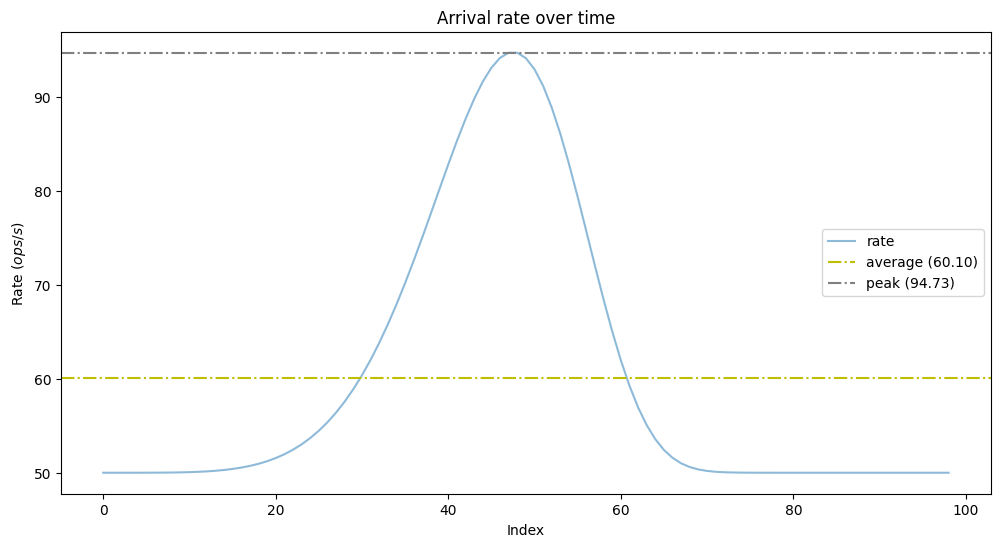

In [47]:
NUMBER_OF_SAMPLES = 100
BASELINE_ARRIVAL_RATE = 50
PEAK_ARRIVAL_RATE_RATIO = 2.5
STEEPNESS = 6.
# A simple wave pattern generator (based on example https://numpy.org/doc/stable/reference/random/generated/numpy.random.weibull.html)
def weibull_distr(x,n,a):
    return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)

arrival_rate = np.array([
    (weibull_distr(x/NUMBER_OF_SAMPLES*2, 1., STEEPNESS) / PEAK_ARRIVAL_RATE_RATIO + 1) * BASELINE_ARRIVAL_RATE
    for x in range(1,NUMBER_OF_SAMPLES)
])

plt.title("Arrival rate over time")
plt.ylabel("Rate ($ops/s$)")
plt.xlabel("Index")
plt.plot(arrival_rate, alpha=0.5, label='rate')
plt.axhline(y=arrival_rate.mean(), color='y', linestyle='-.', label=f'average ({arrival_rate.mean():.2f})')
plt.axhline(y=arrival_rate.max(), color='grey', linestyle='-.', label=f'peak ({arrival_rate.max():.2f})')
plt.legend()
plt.show()

As we can see we have the baseline arrival rate of $~50ops/s$, the maximum doubled at $~95ops/s$, and the mean is $60ops/s$. Is it enough to follow Little's law blindly and provision to avearage throughput in this case? What will be the latency at the peak during utilization icrease? Let's model this example to answer those questions.

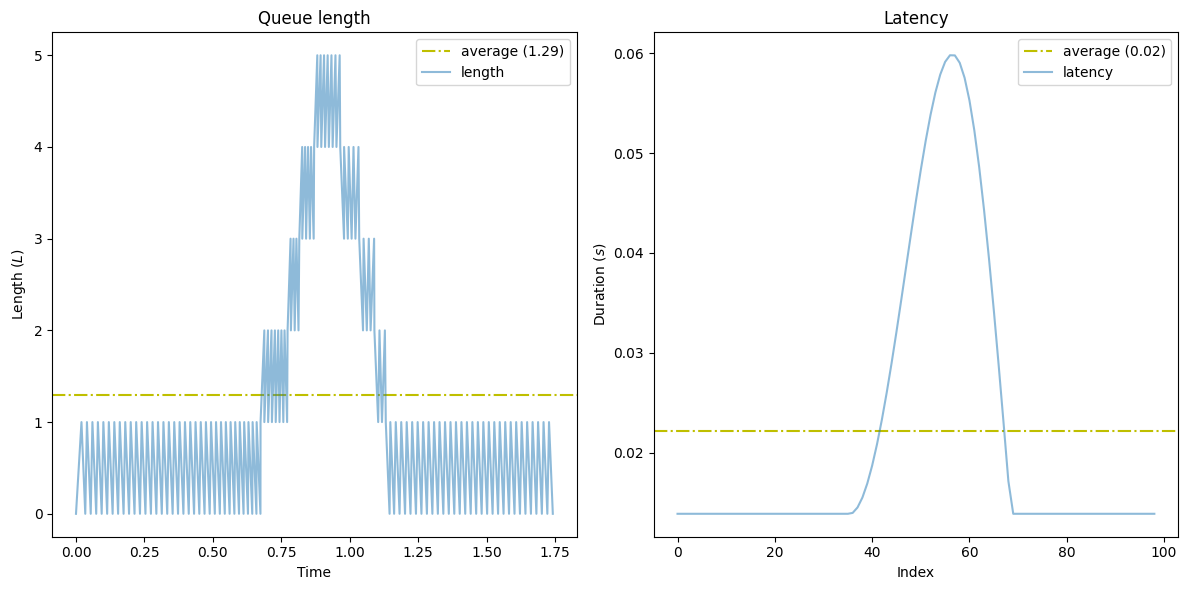

In [64]:
# Have a bit faster throughput, than arrival rate.
THROUGHPUT_MULTIPLIER = 1.2
service_rate = arrival_rate.mean() * THROUGHPUT_MULTIPLIER
service_intervals = np.full(shape=len(arrival_rate), dtype=float, fill_value=1 / service_rate)
queue = Queue(1 / arrival_rate, service_intervals, executors=1)
queue.process()

fig, (queue_length_time, wait_times) = plt.subplots(1, 2)

queue_length_time.set_title("Queue length")
queue_length_time.set(xlabel='Time', ylabel=r'Length ($L$)')
queue_length_time.axhline(y=queue.length.mean(), color='y', linestyle='-.', label=f'average ({queue.length.mean():.2f})')
queue_length_time.plot(*zip(*queue.length_with_timestamps), alpha=0.5, label='length')
queue_length_time.legend()

wait_times.set_title("Latency")
wait_times.set(xlabel='Index', ylabel=r'Duration ($s$)')
wait_times.axhline(y=queue.wait_times.mean(), color='y', linestyle='-.', label=f'average ({queue.wait_times.mean():.2f})')
wait_times.plot(queue.wait_times, alpha=0.5, label='latency')
wait_times.legend()

fig.tight_layout()
plt.show()

We have $~120\%$ of the mean arrival rate for this period. This will allow us to process all the elements during the peak period with a maximum latency of 60 ms. Changing the ratio between throughput and mean arrival rate will result in a different maximum latency for peak periods. Overall the experienced latency during peaks was determined more or less by these factors.

- Ratio of maximum and mean arrival rate (here we had approximately double of the baseline).
- Ratio between throughput and mean arrival rate (how much we overprovision).

> Why does this matter and how can't we just rely on autoscaling? It mainly depends on our scaling performance. Often bootstrapping and warming up new instances requires even $~30sec$! During this period the rest of the instances must handle more load than average. With the model above we can better estimate their behavior and the expected latency penalty.

## Synthetic workloads
The arrival distribution can be various - imagine a situation where you have evenly distributed IoT traffic over the whole day. By writing an experiment similar to the one above you can make your own research. No need to do an elaborate performance test to get some rough numbers. Similar questions may arise from various scenarios when a reliable queuing model can aid us. Typical use cases we need to investigate could be:

- Can we reduce latency by doubling the number of instances for a given scenario? What's the expected latency?
- Can we keep our SLA by having a $90th$ percentile latency of $100ms$ with $120\%$ of the current load?
- How many workers do I need for a given rate of requests over a pub-sub topic if the latency can't exceed $500ms$?


# Monitoring queues - autoscaling
In summary, as I mentioned before **queues are either full or nearly empty**. All of the above hints that we **must** actively monitor queue length and utilization. It seems to be a good idea to connect these two metrics with autoscaling: Scaling out improves latency when we're overutilized and the benefit on latency becomes zero after a certain point. But what's the ideal target utilization? To understand this value better, we need reason about the _variance_ of the incoming load. It's rarely evenly distributed. For this specific scenario, we'll assume that there could be outliers and use an exponential distribution for the arrival rate. We'll have a fixed execution rate of $50ops/s$ and increasing mean arrival rate from $1 ops/s$ to $50 ops/s$

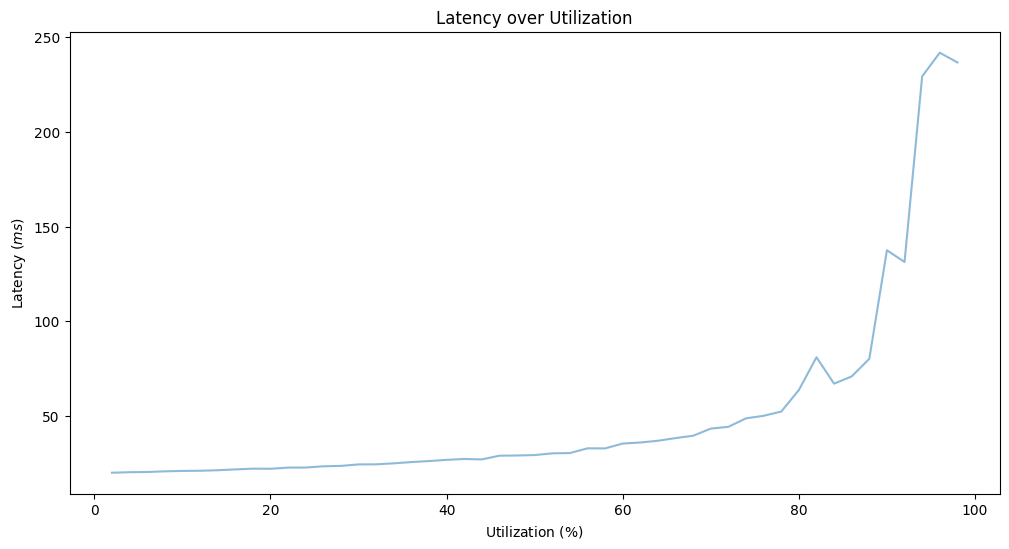

In [92]:
EXECUTION_RATE = 50
SAMPLE_SIZE = 5000
mean_arrival_rates = np.array(range(1, 50))

# arrival rate -> ms
def get_mean_wait_times(mean_arrival_rate):
    execution_interval_in_ms = 1/EXECUTION_RATE * 1000
    mean_arrival_interval_in_ms = 1/mean_arrival_rate * 1000
    queue = Queue(
        np.random.exponential(scale=mean_arrival_interval_in_ms, size=SAMPLE_SIZE),
        np.full(shape=SAMPLE_SIZE, dtype=float, fill_value=execution_interval_in_ms)
    )
    queue.process()
    return queue.wait_times.mean()

plt.title("Latency over Utilization")
plt.xlabel(r'Utilization ($\%$)')
plt.ylabel(r'Latency ($ms$)')
plt.plot(
    mean_arrival_rates / EXECUTION_RATE * 100,
    [ get_mean_wait_times(rate) for rate in mean_arrival_rates ],
    alpha=0.5
)
plt.show()

> Based on the model if we want to keep the latency under 50 ms, we can't have utilization larger than $~60\%$. Note, that this model is considering the variance of the arrival rate, by not using a constant rate. For more about this topic, feel free to investigate [M/D/1 queues](https://en.wikipedia.org/wiki/M/D/1_queue#Relations_for_Mean_Waiting_Time_in_M/M/1_and_M/D/1_queues) and related formulas.

## Monitoring targets
To understand our system better, good targets for monitoring could be:

- queue length (if the chosen technology allows it)
- the difference between p99 and mean latency - this can give us a hint on the queue length, as we've seen in the first basic examples and calculations.
- latency distribution and heat maps - [See Brendan Gregg's detailed article](https://www.brendangregg.com/HeatMaps/latency.html).
- latency on each layer and the difference between them

# Additional examples
⚠️TODO

# References
## Wikipedia
- https://en.wikipedia.org/wiki/Queueing_theory
- https://en.wikipedia.org/wiki/Kendall%27s_notation
- https://en.wikipedia.org/wiki/Little%27s_law

## Various
- http://elearning.kocw.net/document/lec/2012/JoongAng/ChaHoonSang/7.pdf
- http://elearning.kocw.net/document/lec/2012/JoongAng/ChaHoonSang/8.pdf
- https://qmodels.readthedocs.io/en/latest/mm1.html
- https://www.youtube.com/watch?v=12XbrjiZ1FA
- https://github.com/miguelrizzog96/Queue_Simulation_Python/blob/master/server.ipynb
- https://notebook.community/xunilrj/sandbox/courses/IMTx-Queue-Theory/Week2_Lab_MM1
- https://github.com/eveneveno/MMC_queue
- https://github.com/miguelrizzog96/Queue_Simulation_Python
- [Site Reliable Engineering - Four golden signals](https://sre.google/sre-book/monitoring-distributed-systems/#xref_monitoring_golden-signals)
- https://www.brendangregg.com/HeatMaps/latency.html

## Distributions
- https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html

## Numpy
- https://numpy.org/doc/stable/user/basics.creation.html